In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
base_path = "./data_nerf/"
models_path = ["vi_nerf_vis","ml_nerf_vis"]
path_ = base_path + models_path[1]

In [3]:
spatial_= torch.load(path_+"/view3/sample0/spatial_size.pt")

In [4]:
spatial_

[1, 256, 256, 128]

In [5]:
angle = 300
v = 13

In [6]:
rays_worlds = []
rays_density = []
rays_colors =[]
for b in range(16):
    bn = b
    rays_colors.append(torch.load(path_+f"/view{v}/sample0/batch"+str(b)+"/rays_colors.pt"))
    rays_density.append(torch.load(path_+f"/view{v}/sample0/batch"+str(b)+"/rays_densities.pt"))
    rays_worlds.append(torch.load(path_+f"/view{v}/sample0/batch"+str(b)+"/rays_points_world.pt"))
rays_worlds=torch.stack(rays_worlds)
rays_density = torch.stack(rays_density)
rays_colors = torch.stack(rays_colors)

In [7]:
path_vi = base_path + models_path[0]

rays_worlds_vi = []
rays_density_vi = []
rays_colors_vi = []
for sample in range(8):
    rays_density_s = []
    rays_worlds_s = []
    rays_colors_s = []
    for b in range(16):
        bn = b
        rays_colors_s.append(torch.load(path_vi+f"/view{v}/sample"+str(sample)+"/batch"+str(b)+"/rays_colors.pt"))
        rays_density_s.append(torch.load(path_vi+f"/view{v}/sample"+str(sample)+"/batch"+str(b)+"/rays_densities.pt"))
        rays_worlds_s.append(torch.load(path_vi+f"/view{v}/sample"+str(sample)+"/batch"+str(b)+"/rays_points_world.pt"))
    rays_worlds_vi.append(torch.stack(rays_worlds_s))
    rays_density_vi.append(torch.stack(rays_density_s))
    rays_colors_vi.append(torch.stack(rays_colors_s))
rays_worlds_vi=torch.stack(rays_worlds_vi)
rays_density_vi = torch.stack(rays_density_vi)
rays_colors_vi = torch.stack(rays_colors_vi)

In [8]:
rays_worlds_vi=rays_worlds_vi.reshape([8,16*4096*128,3])
rays_density_vi = rays_density_vi.reshape([8,16*4096*128,1])
rays_density_vi_std = rays_density_vi.std(0)
rays_density_vi_mu = rays_density_vi.mean(0)
rays_worlds_vi.shape

torch.Size([8, 8388608, 3])

In [9]:
rays_worlds_vi[0].eq(rays_worlds_vi).all()

tensor(True)

In [10]:
rays_worlds_flat= rays_worlds.reshape(-1,3)
rays_colors_flat = rays_colors.reshape(-1,3)
rays_colors_vi_flat = rays_colors_vi.reshape([8,16*4096*128,3])
rays_colors_vi_flat_std = rays_colors_vi_flat.std(0).mean(-1)[:,None]
rays_colors_vi_flat_mu = rays_colors_vi_flat.mean(0)

In [11]:
rays_density_flat = rays_density.reshape(-1,1)

In [12]:
rays_density_flat.shape

torch.Size([8388608, 1])

In [13]:
rays_colors_vi_flat_std.shape

torch.Size([8388608, 1])

## Filter out empty voxels to make viz feasible (interesting to play with between 0,0.01,0.75)

In [14]:
ind_nzero = rays_density_flat[:,0] != 0
ind_nzero.sum()

#here you can set the threshold
ind_sel = rays_density_flat[:,0]>0.#0.75#0.8#0.7#0.5#0.205#0.01

rays_density_sel = rays_density_flat[ind_sel]
rays_sel = rays_worlds_flat[ind_sel,:]

density_std_sel = rays_density_vi_std[ind_sel]
density_mu_sel = rays_density_vi_mu[ind_sel]
density_vi_sel = rays_density_vi[:,ind_sel,:]


colors_sel = rays_colors_flat[ind_sel,:] 
colors_vi_sel = rays_colors_vi_flat[:,ind_sel,:]
colors_vi_mu = rays_colors_vi_flat_mu[ind_sel,:]
colors_vi_std = rays_colors_vi_flat_std[ind_sel,:]

ind_sel.sum()

tensor(618200)

In [15]:
rays_sel.shape#max()

torch.Size([618200, 3])

In [16]:
rays_density_flat[:,0].numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [17]:
(rays_density_sel[:,0].numpy()).min()

1.1920929e-07

Text(0.5, 0.92, 'Colour')

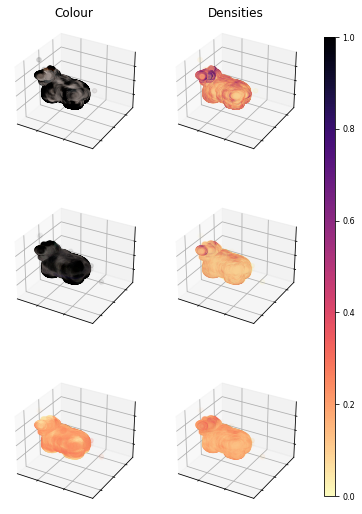

In [19]:
elev = 30

cmap = cm.get_cmap("magma_r")

fig = plt.figure(figsize=(0.9 * 6.75, 0.9 * 3 * 6.75 / 2))

def make_pretty(ax):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(elev, angle)
    

ax0 = fig.add_subplot(322, projection="3d")
c = cmap(rays_density_sel.squeeze(-1).numpy())
c[:, 3] = rays_density_sel.squeeze(-1).numpy()
sct = ax0.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1],
                  c=c)
make_pretty(ax0)

ax1 = fig.add_subplot(324, projection="3d")
c = cmap(density_mu_sel.squeeze(-1).numpy())
c[:, 3] = density_mu_sel.squeeze(-1).numpy()
ax1.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1],
            c=c)
make_pretty(ax1)

ax2 = fig.add_subplot(326, projection="3d")
c = cmap(density_std_sel.squeeze(-1).numpy())
c[:, 3] = density_mu_sel.squeeze(-1).numpy()
ax2.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1],
            c=c)
#            vmin=0, vmax=1, cmap="magma_r")
make_pretty(ax2)

ax3 = fig.add_subplot(321, projection="3d")
ax3.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1],
            c=torch.cat([colors_sel, rays_density_sel], dim=-1))
make_pretty(ax3)

ax4 = fig.add_subplot(323, projection="3d")
ax4.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1],
            c=torch.cat([colors_vi_mu, density_mu_sel], dim=-1))
make_pretty(ax4)

ax5 = fig.add_subplot(325, projection="3d")
c = cmap(colors_vi_std.squeeze(-1).numpy())
c[:, 3] = density_mu_sel.squeeze(-1).numpy()
ax5.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=c)
make_pretty(ax5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
# fig.subplots_adjust(bottom=0.15)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.75, 0.02])
# cbar = fig.colorbar(sct, cax=cbar_ax)
cbar = fig.colorbar(cm.ScalarMappable(Normalize(0, 1), cmap), cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)


# ax0.set_title("ML", fontsize=10)
# ax1.set_title("VI", fontsize=10)
# ax2.set_title("Uncertainty", fontsize=10)
ax0.set_title("Densities")
ax3.set_title("Colour")


# fig.savefig(f"3dnerf_view{v}.png", bbox_inches="tight", dpi=300)

## Visualizing The MLE Predictions For Latent Densities and Colors of NeRF

Text(0.5, 0.92, 'Predictive Density With ML')

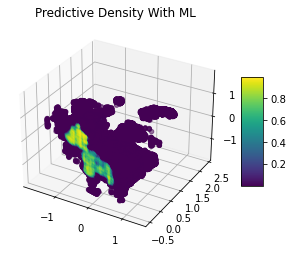

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=rays_density_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Density With ML")

Text(0.5, 0.92, 'Predictive Colors With ML')

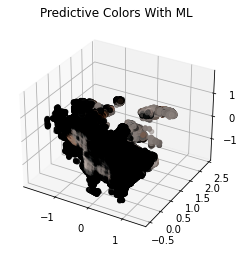

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_sel)
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Colors With ML")

## Visualizing the Bayesian Predictions For Latent Densities and Colors of NeRF

Text(0.5, 0.92, 'Predictive Std. over Density')

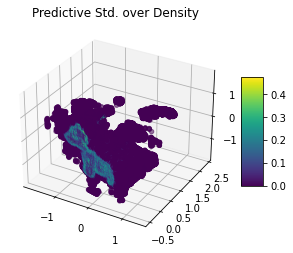

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_std_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Std. over Density")



Text(0.5, 0.92, 'Predictive mean over Density')

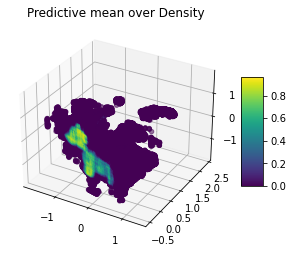

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_mu_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive mean over Density")




Text(0.5, 0.92, 'Sample 1 over Density')

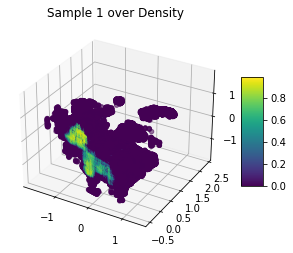

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[0,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 1 over Density")




Text(0.5, 0.92, 'Sample 2 over Density')

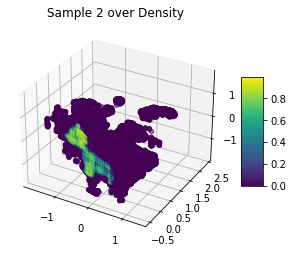

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[1,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 2 over Density")




Text(0.5, 0.92, 'Sample 3 over Density')

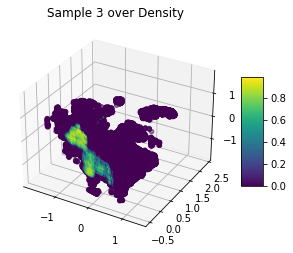

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[2,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 3 over Density")




## Colors

Text(0.5, 0.92, 'Predictive mean over Colors')

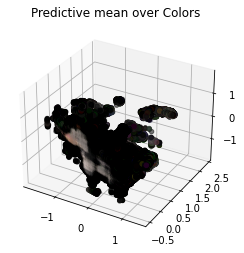

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_mu)
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive mean over Colors")




Text(0.5, 0.92, 'Predictive Std. over Colors')

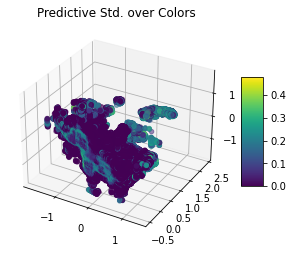

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_std)
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Std. over Colors")

Text(0.5, 0.92, 'Sample 1 over Colors')

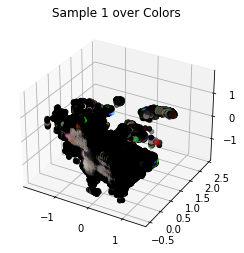

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[0])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 1 over Colors")



Text(0.5, 0.92, 'Sample 2 over Colors')

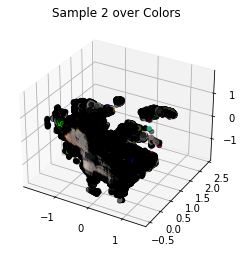

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[1])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 2 over Colors")

Text(0.5, 0.92, 'Sample 3 over Colors')

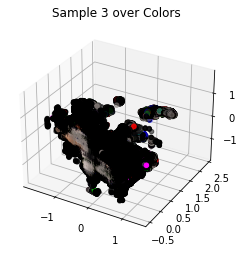

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[2])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 3 over Colors")

Text(0.5, 0.92, 'Sample 4 over Colors')

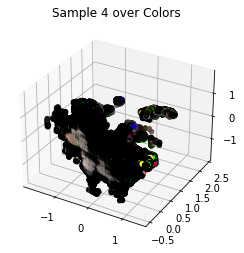

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[3])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 4 over Colors")

Text(0.5, 0.92, 'Sample 5 over Colors')

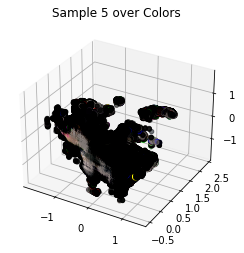

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[4])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 5 over Colors")

Text(0.5, 0.92, 'Sample 6 over Colors')

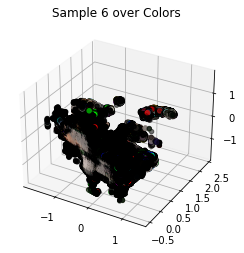

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[5])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 6 over Colors")


Text(0.5, 0.92, 'Sample 7 over Colors')

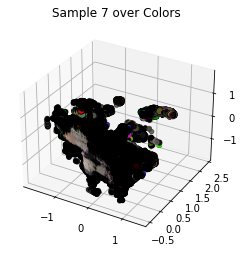

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[6])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 7 over Colors")

Text(0.5, 0.92, 'Sample 8 over Colors')

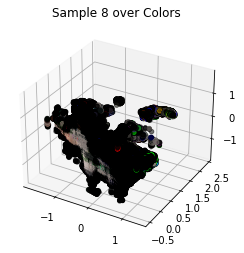

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[7])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 8 over Colors")

## This is how we can visualize stuff without needing to filter, since the alpha will aproppriately weigh all effects. Problem is: alpha cannot be passed as a tensor, so we have to loop through each point and it takes long. Advantage: the results come out naturally

Text(0.5, 0.92, 'Sample 8 over Colors with alpha')

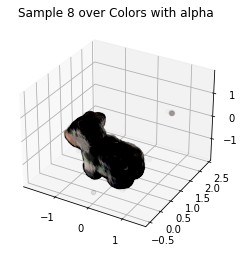

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for iin in range(rays_sel.shape[0]):
    sct = ax.scatter(rays_sel[iin,2],rays_sel[iin,0],rays_sel[iin,1], c=colors_vi_sel[7,iin,:][None,], alpha=density_vi_sel[7,iin].item())
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 8 over Colors with alpha")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rays_worlds_vi[0, :, 2],rays_worlds_vi[0, :, 0],rays_worlds_vi[0, :, 1],
           c=torch.cat((rays_colors_vi_flat_mu, rays_density_vi_mu), dim=-1))

In [11]:
rays_density_vi_mu_flat.shape

NameError: name 'rays_density_vi_mu_flat' is not defined